# exploration13. BERT를 활용한 인간보다 퀴즈를 잘푸는 인공지능 만들기
  
### Dataset: KorQuad  
#### 1. 기계독해(MRC, Machine Reading Comprehension)  
● 기계독해란 인공지능이 스스로 문제를 분석하고 질문에 최적화된 답안을 찾아내는 기술을 말합니다.  
● MRC의 대표적인 기술적 활용은 <b>QA(Question Answer)</b>입니다. 다양한 데이터 속에서 키워드 기반이 아닌 사용자 의도를 분석해 원하는 답을 찾아줍니다.  
● <b>비욘드 서치(Beyond Search)</b>라고도 이야기 됩니다.  
● 이번 프로젝트도 퀴즈를 제시했을 때 인공지능이 얼마나 정답에 가까운 해답을 제시하는지 확인해 볼 것입니다.  
  
#### 2. <b>SQuAD(Standford Question Answering Dataset)</b>  
● 위키피디아 등 방대한 문서 풀을 통해 구축한 데이터로 EM(Exact Match Score), F1 Score 등의 스코얼르 측정하는 테스트 세트입니다.  
● 모델을 업로드하면 이해력 및 정확도 스코어가 표시됩니다.  
  
#### 3. <b>KorQuAD(The Korean Question Answering Dataset, 한국어 질의응답 데이터셋)</b>  

● KorQuAD는 미국 스탠퍼드 대학에서 구축한 대용량 데이터셋인 SQuAD를 벤치마킹한 것입니다. 여기서 사용할 버전은 KorQuAD 1.0으로 Wikipedia articel에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍으로, Training set 60,407개, Dev set 5,774 개의 질의응답쌍으로 구분되어 있습니다.  
● <b>KorQuAD 데이터 전처리</b>(전처리의 구체적인 내용은 아래에 기술하겠습니다.)  
1. 띄어쓰기 단위 정보관리
2. Tokenize by Vocab
3. Improve Span  
4. 데이터셋 분리  

In [ ]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

#### print_json_tree() 메서드  
json 포맷으로 이루어진 데이터에서 리스트의 첫번째 아이템의 실제 내용을 확인해주는 메서드

In [ ]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data' #데이터 로드 
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

# 훈련데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [ ]:
#- 검증데이터 확인
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


In [ ]:
print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False)) #json데이터의 실제 형태 확인 

{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "교향곡",
              "answer_start": 54
            }
          ],
          "id": "6566495-0-0",
          "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"
        },
        {
          "answers": [
            {
              "text": "1악장",
              "answer_start": 421
            }
          ],
          "id": "6566495-0-1",
          "question": "바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?"
        },
        {
          "answers": [
            {
              "text": "베토벤의 교향곡 9번",
              "answer_start": 194
            }
          ],
          "id": "6566495-0-2",
          "question": "바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?"
        },
        {
          "answers": [
            {
              "text": "파우스트",
              "answer_start": 15
            }
          ],
          "id": "6566518-0-0",
          "question": "1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?"
        },
        {
    

# KorQuAD 전처리(1) 띄어쓰기 단위 정보관리  
● c는 음절(Hangul syllable)에 해당, 예를들어 '파우스트'는 '파', '우', '스', '트'의 4 음절로 구성되어 있습니다.  
● _is_whitespace 메서드는 c가 공백이면 True, 아니면 False를 반환  
● word_tokens는 어절 단위 그러니까 문장을 공백을 기준으로 단어를 분리해 저장하는 리스트입니다.  
● char_to_word는 정수 시퀀스로 이뤄진 리스트, 단어+공백까지 같은 정수로 맵핑되고 공백이후 숫자 1을 더합니다. 즉, 띄어쓰기 단위의 정보를 관리합니다.  

In [ ]:
def _is_whitespace(c): #- 공백여부를 반환하는 함수
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [ ]:
#샘플 데이터 2개로 전처리 과정을 확인 합니다. 
string1 = '1839년 파우스트를 읽었다.' #- 공백이 1개
string2 = '1839년  파우스트를 읽었다.' #- 공백이 2개
string1[6:10], string2[7:11]

('파우스트', '파우스트')

In [ ]:
#두 문장에 대해 글자별 띄어쓰기 영역 정보 관리
word_tokens = [] #character별 저장
char_to_word = [] #띄어쓰기 구분 해주는 정수 시퀀스 저장 
prev_is_whitespace = True #이전 글자가 공백인지 여부

#- 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보 표시
for c in string1: #- 반복문을 통해 문장 string1 을 구성하는 character를 하나씩 호출
    if _is_whitespace(c): #c가 공백일 경우
        prev_is_whitespace = True
    else: #c가 공백이 아닐 경우
        if prev_is_whitespace: #이전 글자가 공백일 때 
            word_tokens.append(c) #word_token에 c 저장  
        else: #현재 글자가 공백이 아니고 이전 글자가 공백이 아닐 때 
            word_tokens[-1] += c #word_tokens의 마지막 인덱스에 c를 추가
        prev_is_whitespace = False #prev_is_whitespace에 False 할당
    char_to_word.append(len(word_tokens)-1) #char_to_word에 (len(word_tokens)-1)을 추가
    print(f'\'{c}\':{word_tokens}:{char_to_word}')

'1':['1']:[0]
'8':['18']:[0, 0]
'3':['183']:[0, 0, 0]
'9':['1839']:[0, 0, 0, 0]
'년':['1839년']:[0, 0, 0, 0, 0]
' ':['1839년']:[0, 0, 0, 0, 0, 0]
'파':['1839년', '파']:[0, 0, 0, 0, 0, 0, 1]
'우':['1839년', '파우']:[0, 0, 0, 0, 0, 0, 1, 1]
'스':['1839년', '파우스']:[0, 0, 0, 0, 0, 0, 1, 1, 1]
'트':['1839년', '파우스트']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를':['1839년', '파우스트를']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ':['1839년', '파우스트를']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽':['1839년', '파우스트를', '읽']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었':['1839년', '파우스트를', '읽었']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다':['1839년', '파우스트를', '읽었다']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.':['1839년', '파우스트를', '읽었다.']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


● 위의 과정을 _tokenize_whitespace 함수(띄어쓰기 단위정보관리 함수)로 정리합니다.    
● 해당 함수는 word_tokens와 char_to_word를 반환합니다.

In [ ]:
#- 공백을 토큰화하는 함수
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string: 
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

● string1, string2를 입력하여 함수가 잘 작동하는지를 확인합니다. 

In [ ]:
# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [ ]:
# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

# KorQuAD 데이터셋 전처리 (2) Tokenize by Vocab(SentencePiece )  
● 구글이 제공하는 SentencePiece를 활용하여 Subword 기반의 텍스트 전처리 진행할 것입니다.  
● SentencePiece는 사전 토큰화 작업없이 단어 분리 토큰화를 수행하므로 언어에 종속되지 않고 사용될 수 있다는 장점이 있습니다.  
● 이러한 장점 덕분에 한국어를 형태소 분리가 아닌 통계적인 방법으로 전처리 해줍니다.  
● context_tokens는 공백을 '_'로 저장하고 sentencepiece로 통해 쪼개진 단어를 저장합니다.  
● word_to_token는 공백이 들어간 토큰의 위치(인덱스)를 저장합니다.  

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model") #ko_32000.model 이름으로 저장된 모델 불러옴 

# word를 subword로 변경하면서 index 저장
word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens): #단어 단위 토큰을 불러옵니다.
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)  # SentencePiece를 사용해 Subword로 쪼갭니다.
    for token in tokens:
        context_tokens.append(token) 

context_tokens, word_to_token

(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

● 위의 과정을 _tokenize_vocab 함수로 만들어줍니다.  

In [ ]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [ ]:
print(word_tokens) #단어 토큰 리스트 

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens) #word_tokens를 SentencePiece로 쪼개줍니다. 
context_tokens, word_to_token #Subword 단위로 토큰화한 결과

['1839년', '파우스트를', '읽었다.']


(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

# KorQuAD 데이터셋 전처리 (3) Improve Span  
● 위에서 확인한 json 파일의 데이터셋에서 context, question, answer를 뽑아줍니다.  
● 위 3가지의 데이터를 뽑는 이유는 인공지능이 question(질문)과 context(지문)을 받으면 지문 영역에서 answer(정답)을 맞추기 때문입니다.  
● 아래는 데이터셋을 활용하여 answer를 찾는 과정의 전처리입니다.  
● assert[조건],[오류메시지]:이 조건이 True이면 그대로 코드가 진행되고, False라면 AssertionError가 발생합니다. 


In [ ]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


●context를 _tokenize_whitespace, _tokenize_vocab를 거치면서 단어 단위로 토큰화 → Subword로 토큰화 합니다. 

In [ ]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [ ]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [ ]:
#- answer_start 와 answer_end로부터 word_start와 word_end를 구합니다.
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

● word_tokens의 결과가 '교향곡을'이고 우리가 원하는 정답은 '교향곡' 입니다. 따라서 word_start로부터 word_end까지의 context를 Subword 단위 로 토큰화한 결과를 확인합니다.  

In [ ]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

● Subword 단위로 토큰화한 결과는 '_교향곡' 입니다. 다른 방법으로 정답 토큰을 찾아보겠습니다.  

In [ ]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

● 정답과 일치하는 경우 '_교향곡'이 출력됩니다. 이는 위의 Subword 단위로 토큰화한 경우와 동일한 결과입니다.  

In [ ]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)]) 
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else: #정답과 불일치
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


● 위의 과정을 _improve_span 함수로 변환합니다. 해당 함수는 토큰화된 context를 입력 받아 answer의 위치를 찾아 반환 합니다.  
● vocab.encode_as_pieces은 subword token으로 변화시켜주는 함수 입니다.  

In [ ]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
            
    return (token_start, token_end)

In [ ]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

# KorQuAD 데이터셋 전처리 (4) 데이터셋 분리  
● train 데이터셋, dev 데이터셋을 분리하여, 위에서 작성한 _improve_span() 함수를 이용해 전처리 후 파일로 저장합니다.

In [ ]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [ ]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

● 전처리가 의도대로 잘 되었는지 실제로 파일 내용을 확인합니다.

In [ ]:
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

# KorQuAD 데이터셋 전처리 (5) 데이터 분석 : Question  
● 전처리된 데이터를 실제로 사용할 수 있을지 혹은 이상(abnormal) 데이터가 존재하는지 분석 합니다.  
● question 항목의 길이 분포 조사  

In [ ]:
questions = [] #질문 
contexts = [] #문맥내용 
token_starts = [] #토큰 시작위치 
with open(f"{data_dir}/korquad_train.json") as f: #train data 파일 open
    for i, line in enumerate(f): #파일 내용 순회
        data = json.loads(line) #json 문자열을 python의 객체로 변환  
        questions.append(data["question"]) #질문 저장
        contexts.append(data["context"]) #문맥 내용 저장
        token_starts.append(data["token_start"]) #토큰 시작 위치 저장
        if i < 10: #10개만 출력  
            print(data["token_start"], data["question"])

19 ['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?']
168 ['▁바그너', '는', '▁교향곡', '▁작곡', '을', '▁어디', '까지', '▁쓴', '▁뒤에', '▁중단', '했', '는', '가', '?']
80 ['▁바그너', '가', '▁', '파우스트', '▁서', '곡을', '▁쓸', '▁때', '▁어떤', '▁곡', '의', '▁영향을', '▁받았', '는', '가', '?']
6 ['▁1839', '년', '▁바그너', '가', '▁교향곡', '의', '▁소재로', '▁쓰', '려고', '▁했던', '▁책은', '?']
143 ['▁', '파우스트', '▁서', '곡', '의', '▁라', '단', '조', '▁조성', '이', '▁영향을', '▁받은', '▁베토벤', '의', '▁곡은', '?']
0 ['▁바그너', '가', '▁', '파우스트', '를', '▁처음으로', '▁읽', '은', '▁', '년', '도', '는', '?']
165 ['▁바그너', '가', '▁처음', '▁교향곡', '▁작곡', '을', '▁한', '▁장소', '는', '?']
216 ['▁바그너', '의', '▁1', '악장', '의', '▁초연', '은', '▁어디서', '▁연주', '되었', '는', '가', '?']
164 ['▁바그너', '의', '▁작품을', '▁시인', '의', '▁피로', '▁쓰여', '졌다', '고', '▁극찬', '한', '▁것은', '▁누구', '인', '가', '?']
7 ['▁잊', '혀', '져', '▁있는', '▁', '파우스트', '▁서', '곡', '▁1', '악장', '을', '▁부활', '시킨', '▁것은', '▁누구', '인', '가', '?']


In [ ]:
# token count
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

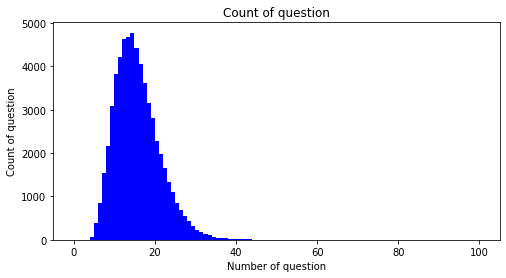

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
# 그래프 제목
plt.title('Count of question')
# 그래프 x 축 라벨
plt.xlabel('Number of question')
# 그래프 y 축 라벨
plt.ylabel('Count of question')
plt.show()

In [ ]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


● question 전체 75%의 길이는 18.00 이하의 길이를 가집니다.  
● question MAX/100분위는 28.50으로 이 이상의 값은 상한 이상치일 수 있습니다.  

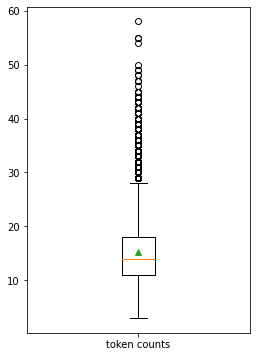

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

# KorQuAD 데이터셋 전처리 (7) 데이터 분석 : Answer  
● 위와 동일한 방법으로 answer 항목에 대해서도 분석해 봅니다.

In [ ]:
# token count
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

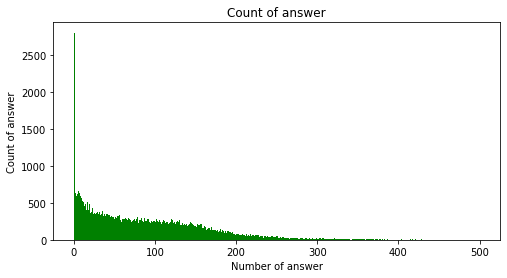

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
# 그래프 제목
plt.title('Count of answer')
# 그래프 x 축 라벨
plt.xlabel('Number of answer')
# 그래프 y 축 라벨
plt.ylabel('Count of answer')
plt.show()

In [ ]:
# 데이터 길이
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


● answer의 평균 위치는 89.01 이고 전체의 75%는 134 이내에 위치 합니다.  
● answer MAX/100분위는 297.50로 그 이상은 이상치로 볼 수 있습니다.  

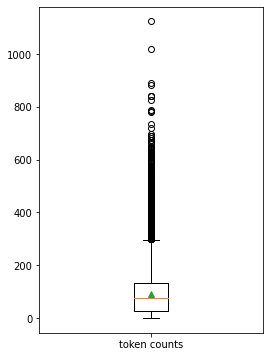

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

# KorQuAD 데이터셋 전처리 (8) 데이터 분석 : Word Cloud  
### Word Cloud  
● 자료의 빈도수를 시각화해서 나타내는 방법, 문서의 핵심단어를 한 눈에 파악할 수 있습니다. 빈도수가 높은 단어일수록 글씨 크기가 큰 특징이 있습니다.  

In [ ]:
# train documents
documents = []

# 전체 데이터에서 title, context, question 문장을 모두 추출합니다. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]   # 그중 맨 앞 10개만 확인해 봅니다.

  0%|          | 0/1420 [00:00<?, ?it/s]

['파우스트_서곡',
 '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
 '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?',
 '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?',
 '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?',
 '바그너가 파우스트를 처음으로 읽은 년도는?',
 '바그너가 처음 교향곡 작곡을 한 장소는?',
 '바그너의 1악장의 초연은 어디서 연주되었는가?']

In [ ]:
# documents를 전부 이어 하나의 문장으로 만들면 이렇게 보입니다. 
" ".join(documents[:10])

'파우스트_서곡 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가? 바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가? 1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은? 파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은? 바그너가 파우스트를 처음으로 읽은 년도는? 바그너가 처음 교향곡 작곡을 한 장소는? 바그너의 1악장의 초연은 어디서 연주되었는가?'

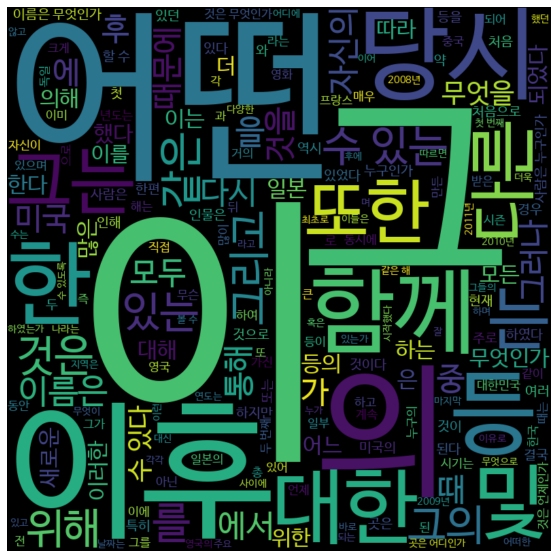

In [ ]:
# WordCloud로 " ".join(documents)를 처리해 봅니다. 
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

● '이', '그', '어떤'의 단어가 가장 눈어 띄는데 이들은 중의적 표현이거아 무언가를 지칭할 때 사용되는 단어 입니다.  
● '이후', '당시' 같은 시제와 관련된 단어도 보입니다.  

# KorQuAD 데이터셋 전처리 (9) 데이터 로드
● 지금까지 만든 데이터셋을 메모리에 로드합니다.

In [ ]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [ ]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [ ]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [ ]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

In [ ]:
# Question과 Context가 포함된 입력데이터 1번째
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [ ]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [ ]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]

(37, 37)

# BERT(Bidirectional Encoder Representations from Transformers)
### 1. BERT 개요
● BERT라는 이름은 세서미 스트리트라는 미국 인형극의 캐릭터 이름에서 가져왔다.  
● 무려 11개의 NLP 태스크에서 state-of-the-art를 기록하면서 뉴욕타임스의 지면을 장식한 모델이다.   
● 위키피디아(25억 단어)와 BooksCorpus(8억 단어)와 같은 레이블이 없는 방대한 데이터로 사전 훈련된 언어 모델  
● BERT의 강점은 <b>파인 튜닝(fine-tuning)</b>인데 레이블이 있는 다른 작업(Task)에서 추가 훈련과 함께 하이퍼파라미터를 재조정 함으로써 다양한 사례에서 좋은 성능을 얻을 수 있다.  
● 기본적으로 <b>transformer의 encoder</b> 부분만 사용  
→ base 버전에는 총 12개를 쌓았음, large 버전에서는 총 24개를 쌓았다.  
→ BERT-Base : L=12, D=768, A=12 : 110M개의 파라미터  
→ BERT-Large : L=24, D=1024, A=16 : 340M개의 파라미터  
→ BERT-Base는 Open AI GPT-1과 하이퍼파라미터가 동일한데 이는 BERT 연구진이 GPT-1과 성능을 비교하기 위해서 동등한 크기로 설계했기 때문이다.  
→ BERT-Large는 BERT의 최대 성능을 보여주기 위해 만들어진 모델  
● BERT는 두 가지 unsupervised task로 pre-train 시킨 모델이다.  

### 2.BERT 입력  
#### 포지션 임베딩(Position Embedding)  
● 트랜스포머와 다르게 단어의 위치 정보를 사인 코사인 함수가 아닌 학습을 통해서 얻는다.  
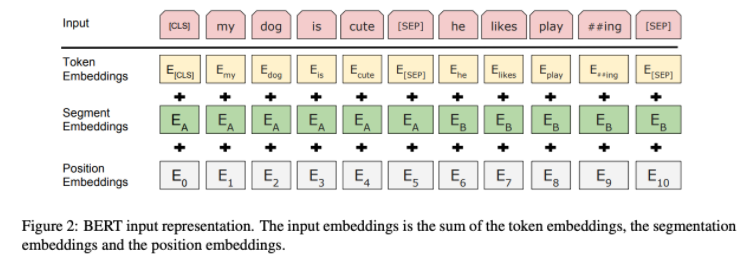



● BERT에는 총 3개의 임베딩 층이 사용됩니다.  
1. WordPiece Embedding: 실질적인 입력이 되는 워드 임베딩, 임베딩 벡터의 종류는 단어 집합의 크기로 30,522개  
2. Position Embedding: 위치 정보를 학습하기 위한 임베딩, 임베딩 벡터의 종류는 문장의 최대 길이인 512개  
3. Segment Embedding: 두 개의 문장을 구분하기 위한 임베딩, 임베딩 벡터의 종류는 문장의 최대 개수인 2개  
→ 여기서 주의할 점은 QA 문장을 푸는 경우 질문(Question)과 본문(Context)를 입력 받는데 질문과 본문은 다수의 문장으로 구성될 수 있기 때문에 두 종류의 문서, 텍스트가 될 수 있다.  

### 3. BERT의 사전 훈련  
● BERT의 사전 훈련은 크게 두 가지로 나뉜다.  
1. 마스크드 언어 모델(Masked Language Model)  
→ 입력 텍스트의 15% 단어를 랜덤으로 마스킹하고 인공신경망에게 이 가려진 단어들을 예측하도록 함  
→ 랜덤으로 선택된 15% 단어들은 다음과 같은 비율로 추가적 규칙이 적용된다.  
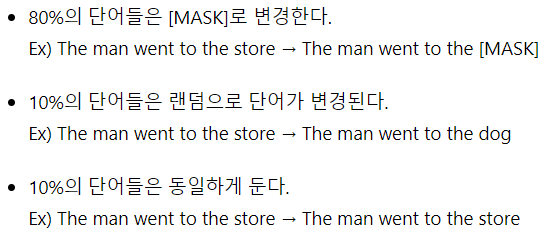  
→ 랜덤으로 선택된 15%의 단어들의 모든 토큰을 [MASK]로 사용하지 않는 이유는 학습 단계에는 [MASK]가 사용되는데 파인튜닝 단계에서 [MASK]가 나타나지 않기 때문에 이 문제를 해결하기 위함이다.  

→ 예를 들어 "My dog is cute, he likes playing"라는 문장을 가정하자. 이는 서브워드 토크나이저에 의해  ['my', 'dog', 'is' 'cute', 'he', 'likes', 'play', '##ing']로 변환된다고 예상할 수 있다.  
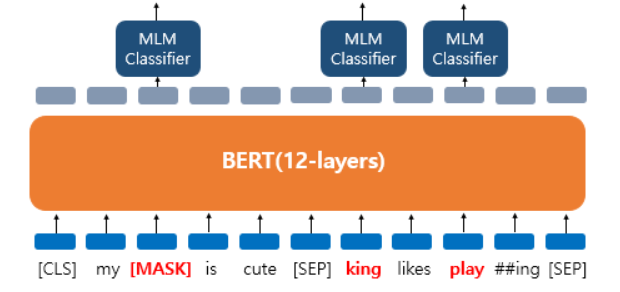  
→ 'dog' 토큰을 [MASK]로 변경  
→ 'he'는 랜덤 단어 'king'으로 변경  
→ 'play'는 변경되진 않았지만 인공신경망은 원래 단어가 무엇인지 맞춰야함  



2. 다음 문장 예측(Next Sentence Prediction, NSP)  
→ BERT는 두 개의 문장을 준 후에 이 문장이 이어지는 문장인지 아닌지를 맞추는 방식으로 훈련  
→ 50:50 비율로 실제로 이어지는 두 개의 문장과 랜덤으로 이어붙인 두 개의 문장을 주고 훈련시킴  
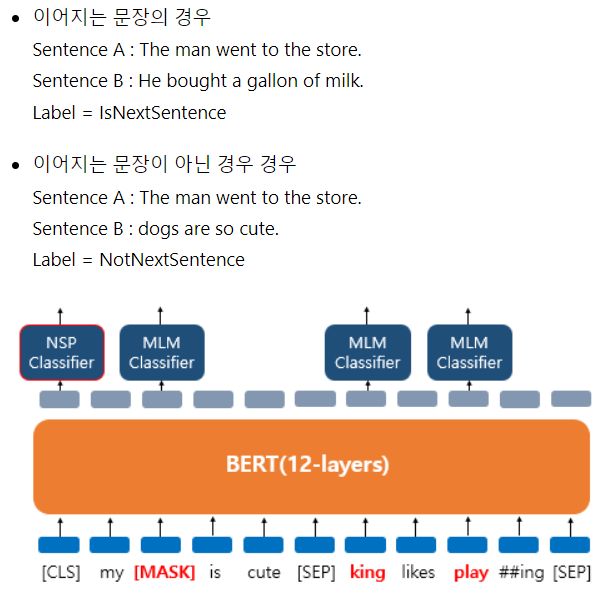  
→[SEP]은 문장을 구분하는 토큰으로 문장이 끝날 때 추가된다.  
→[CLS]은 분류 문제를 풀기 위해 추가된 토큰으로 이 토큰의 출력층에서 두 문장이 실제로 이어지는 문장인지 아닌지를 이진 분류를 통해 판단한다.  
● 이러한 마스크드 언어 모델과 다음 문장 예측은 loss를 합하여 학습이 동시에 이루어진다.  




### 4. BERT contextual Embedding  
● ELMo, GPT-1과 마찬가지로 문맥을 반영한 임베딩을 사용하는데 바로 이점 때문에 문서를 읽고 정답을 맞추는(QA)task에 활용 가능하다.  
● d_model은 768로 정의되어 출력 임베딩에서 각 단어 마다 768 차원의 벡터를 출력한다. 출력 벡터는 문맥 정보를 가지고 있다.  
● 첫 번째 층의 출력 임베딩은 BERT의 두번째 층에서는 입력 임베딩이 된다.  
● 이러한 출력 임베딩은 트랜스포머의 인코더를 12번 쌓은 층을 통과한 결과이고 내부적으로 각 인코더 층은  머피 헤드 셀프 어텐션과 포지션 와이즈 피드 포워드 신경망을 수행하고 있다.  
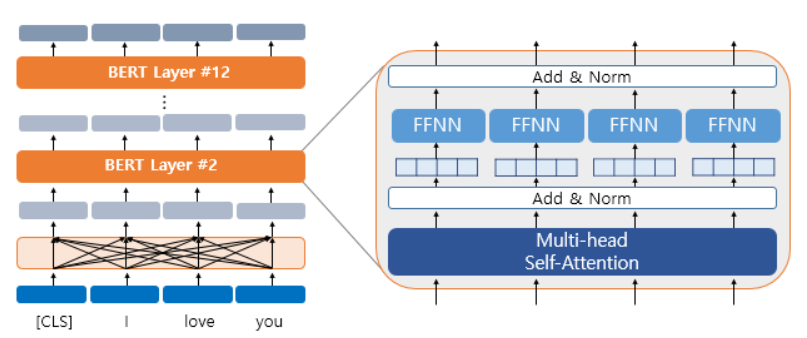    
[Reference](https://wikidocs.net/115055)



### 5.BERT 학습 조건  
● 두 문장 Sentence A와 B의 합한 길이. 즉, 최대 입력의 길이는 512로 제한  
● 100만 step 훈련 ≈ (총 합 33억 단어 코퍼스에 대해 40 에포크 학습)  
● 옵티마이저 : 아담(Adam)  
● 학습률(learning rate) :1e-4   
● 가중치 감소(Weight Decay) : L2 정규화로 0.01 적용  
● 드롭 아웃 : 모든 레이어에 대해서 0.1 적용  
● 활성화 함수 : relu 함수가 아닌 gelu 함수  
● 배치 크기(Batch size) : 256  

In [ ]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):#bert는 adam 대신 bert 사용 
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [ ]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [ ]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [ ]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

● 학습 파라미터 지정  

In [ ]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 12, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 12,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

● 배치 사이즈를 32에서 16으로 줄이겠습니다.  

In [ ]:
bert_batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [ ]:
model = BERT4KorQuAD(config) #bert 모델 정의 

In [ ]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [ ]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

● 논문에 따르면 초기 학습률은 5e-5, 3e-5, 2e-5으로 미세 조정을 위해 아주 작게 설정했다고 합니다.  
● 여기서는 시간 관계상 epoch 3만 학습시킵니다. fine tuning시 3 epochs가 추천되기도 합니다.  
● 텐서플로우 홈페이지의 BERT를 사용한 텍스트 분류에서 optimizer로 adamW를 사용했습니다. 여기서는 Adam을 사용합니다.  
[텐서플로우 공식문서](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

In [ ]:
history1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }

def train_model(history, model, train_dataset, dev_dataset):

    loss_fn = tf.keras.losses.sparse_categorical_crossentropy
    acc_fn = tf.keras.metrics.sparse_categorical_accuracy

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

    best_acc = .0
    patience = 0
    for epoch in range(20):
        train_start_loss, train_end_loss, train_start_acc, train_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)    
        start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
        history['train_loss'].append(train_start_loss+train_end_loss)
        history['train_acc'].append(train_start_acc+train_end_acc)
        history['val_loss'].append(start_loss+end_loss)
        history['val_acc'].append(start_acc+end_acc)
    
        print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    
        acc = start_acc + end_acc
        if best_acc < acc:
            patience = 0
            best_acc = acc
            #model.save_weights(os.path.join(data_dir, "first_korquad_bert_none_pretrain.hdf5"))
            model.save_weights(os.path.join(data_dir, "snd_korquad_bert_pretrain.hdf5"))
            print(f'save best model')
        else:
            patience += 1
        if 2 <= patience:
            print(f'early stopping')
            break
            
    return history

● 배치 사이즈 16일 때 학습입니다. n_vocab=0, range 범위는 20까지 적용했습니다. loss와 acc는 loss_and_history 변수에 저장합니다.  
● pretrain 전 파일을 'first_korquad_bert_none_pretrain.hdf5'로 저장합니다.  

In [ ]:
loss_and_history = train_model(history1, model, train_dataset, dev_dataset)

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9507, acc: 0.0014, 0.0011
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 5.9507, 5.9507, acc: 0.0067, 0.0033
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 5.9507, 5.9507, acc: 0.0018, 0.0016


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 3 >> loss: 5.9507, 5.9507, acc: 0.0014, 0.0000
early stopping


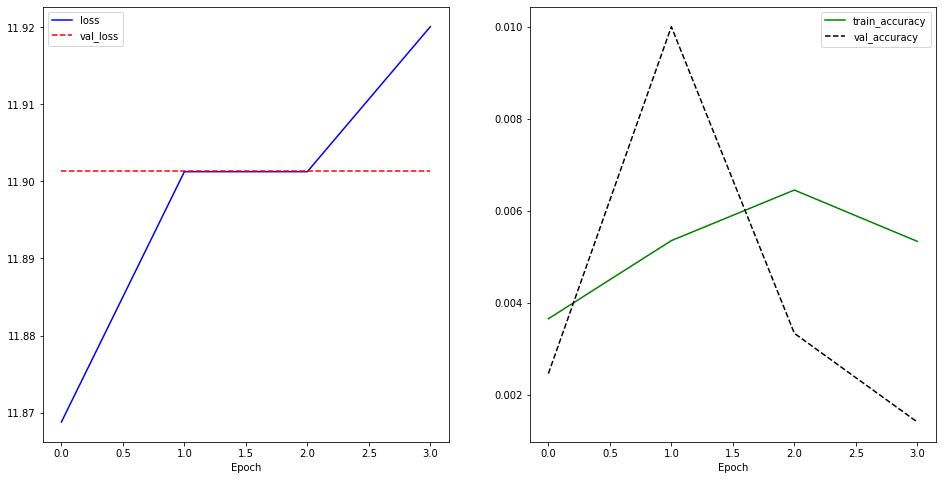

In [ ]:
# training result
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(loss_and_history['train_loss'], 'b-', label='loss')
plt.plot(loss_and_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_and_history['train_acc'], 'g-', label='train_accuracy')
plt.plot(loss_and_history['val_acc'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('./2.png')

plt.show()

● loss와 acc 그래프가 뒤바껴야 하는데 ㅠㅠ  

In [ ]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [ ]:
# training result를 함수로 바꾸겠습니다. 
def history_plot(history):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], 'b-', label='loss')
    plt.plot(history['val_loss'], 'r--', label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], 'g-', label='train_accuracy')
    plt.plot(history['val_acc'], 'k--', label='val_accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('./2.png')

    plt.show()

In [ ]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

corr_dict1 = {'question': [], 'context': [], 'answer': [], 'predicted_answer': [] }
wrong_dict1 = {'question': [], 'context': [], 'answer': [], 'predicted_answer': [] }

def get_predict(corr_dict, wrong_dict, model, dev_json=dev_json):
    corr_answer_count = 0
    wrong_answer_count = 0
    with open(dev_json) as f:
        for i, line in enumerate(f):
            data = json.loads(line)
            question = vocab.decode_pieces(data['question'])
            context = vocab.decode_pieces(data['context'])
            answer = data['answer']
            answer_predict = do_predict(model, question, context)
            
            if answer in answer_predict: #정답을 맞춘 경우 => 일치하는 음절 단위로 acc 계산 
                corr_dict['question'].append(question)
                corr_dict['context'].append(context)
                corr_dict['answer'].append(answer)
                corr_dict['predicted_answer'].append(answer_predict)
                corr_answer_count += 1
                print(i)
                print("질문 : ", question)
                print("지문 : ", context)
                print("정답 : ", answer)
                print("예측 : ", answer_predict, "\n")
        
            else:  
                wrong_dict['question'].append(question)
                wrong_dict['context'].append(context)
                wrong_dict['answer'].append(answer)
                wrong_dict['predicted_answer'].append(answer_predict)
                wrong_answer_count += 1
        
            if 100 < i:
                break
  
    print("정답을 맞춘 개수: {}".format(corr_answer_count))
    print("잘못 맞춘 개수: {}".format(wrong_answer_count))
    
    return corr_dict, wrong_dict

● 예측이 정답에 포함 된 경우 corr_dict1, 예측이 정답에 포함 되지 않을 경우 wrong_dict1에 딕셔너리 형태로 저장  

In [ ]:
corr_dict1, wrong_dict1 = get_predict(corr_dict1, wrong_dict1, model, dev_json=dev_json)

43
질문 :  노아는 누구의 명령에 따라 배를 만들고 가족과 동물들을 태웠는가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 :  하나님
예측 :  동물들을 태웠는가?[SEP] 노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩 

47
질문 :  노아의 방주는 총 몇층으로 되어 있었는가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가

In [ ]:
corr_dict1 = pd.DataFrame(corr_dict1) #데이터프레임 변형 
corr_dict1.to_pickle('pretrained_correct_answers.pkl') #pickle 파일로 저장 
corr_dict1.head()

,question,context,answer,predicted_answer
0,노아는 누구의 명령에 따라 배를 만들고 가족과 동물들을 태웠는가?,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",하나님,동물들을 태웠는가?[SEP] 노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한...
1,노아의 방주는 총 몇층으로 되어 있었는가?,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",3층,총 몇층으로 되어 있었는가?[SEP] 노아는 하나님의 명령에 따라 배를 만들고 가족...
2,1955년 목재의 파편을 발견한 프랑스의 탐험가 이름은?,"일반적으로 터키의 아라랏 산의 경우, 실제 성경 속에 등장하는 아라랏 산은 지금 아...",Fernand Navarra,의 파편을 발견한 프랑스의 탐험가 이름은?[SEP] 일반적으로 터키의 아라랏 산의 ...


In [ ]:
wrong_dict1 = pd.DataFrame(wrong_dict1) #데이터프레임 변환
wrong_dict1.to_pickle('pretrained_wrong_answers.pkl') #pickle 파일로 저장 
wrong_dict1.head()

,question,context,answer,predicted_answer
0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,1989년 2월 15일,[CLS] 임종
1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임수경,[CLS]
2,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,1989년,석이
3,임종석을 검거한 장소는 경희대 내 어디인가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,학생회관 건물 계단,[CLS]
4,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,서울지방경찰청 공안분실,임종석이 조사를 받은


● config에서 n_vocab 값을 지정해주는 걸 깜빡하여 0에서 32007로 값을 변경하고 다시 학습시켰습니다.  

In [ ]:
history2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }
snd_history = train_model(history2, model, train_dataset, dev_dataset)

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9507, acc: 0.0018, 0.0019
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 5.9507, 5.9507, acc: 0.0030, 0.0035
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 5.9507, 5.9507, acc: 0.0023, 0.0023


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 3 >> loss: 5.9507, 5.9507, acc: 0.0019, 0.0030
early stopping


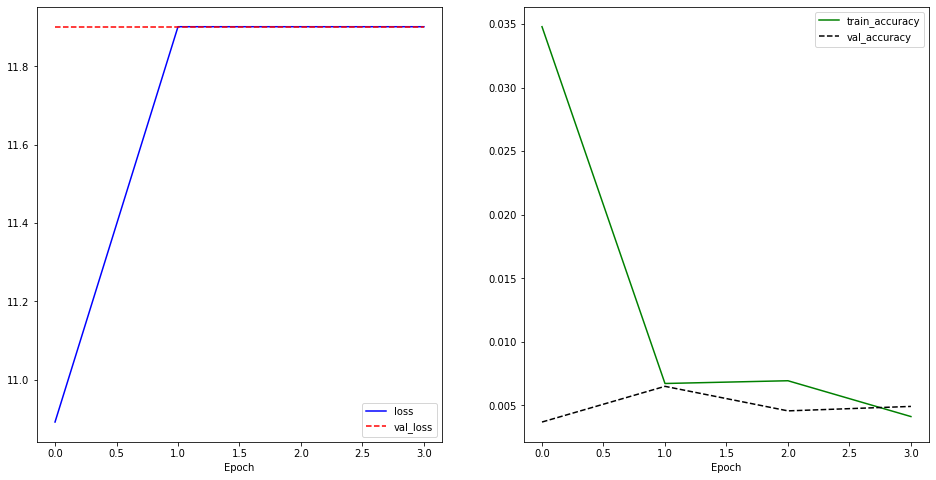

In [ ]:
history_plot(snd_history)

In [ ]:
corr_dict2 = {'question': [], 'context': [], 'answer': [], 'predicted_answer': [] }
wrong_dict2 = {'question': [], 'context': [], 'answer': [], 'predicted_answer': [] }
corr_dict2, wrong_dict2 = get_predict(corr_dict2, wrong_dict2, model, dev_json=dev_json)

7
질문 :  정부의 헌법개정안 준비 과정에 대해서 청와대 비서실이 아니라 국무회의 중심으로 이뤄졌어야 했다고 지적한 원로 헌법학자는?
지문 :  "내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다", "행보가 비서 본연의 역할을 벗어난다"는 의견이 제기되었다. 대표적인 예가 10차 개헌안 발표이다. 원로 헌법학자인 허영 경희대 석좌교수는 정부의 헌법개정안 준비 과정에 대해 "청와대 비서실이 아닌 국무회의 중심으로 이뤄졌어야 했다"고 지적했다. '국무회의의 심의를 거쳐야 한다'(제89조)는 헌법 규정에 충실하지 않았다는 것이다. 그러면서 "법무부 장관을 제쳐놓고 민정수석이 개정안을 설명하는 게 이해가 안 된다"고 지적했다. 민정수석은 국회의원에 대해 책임지는 법무부 장관도 아니고, 국민에 대해 책임지는 사람도 아니기 때문에 정당성이 없고, 단지 대통령의 신임이 있을 뿐이라는 것이다. 또한 국무총리 선출 방식에 대한 기자의 질문에 "문 대통령도 취임 전에 국무총리에게 실질적 권한을 주겠다고 했지만 그러지 못하고 있다. 대통령비서실장만도 못한 권한을 행사하고 있다."고 답변했다.
정답 :  허영
예측 :  대통령비서실의 권한이 너무 크다", "행보가 비서 본연의 역할을 벗어난다"는 의견이 제기되었다. 대표적인 예가 10차 개헌안 발표이다. 원로 헌법학자인 허영 경희대 석좌교수는 정부의 헌법개정안 준비 과정에 대해 "청와대 비서실이 아닌 국무회의 중심으로 이뤄졌어야 했다"고 지적했다. '국무회의의 심의를 거쳐야 한다'(제89조)는 헌법 

14
질문 :  로널드 레이건 대통령 밑에서 일한 국무 장관은 누구인가?
지문 :  알렉산더 메이그스 헤이그 2세(영어: Alexander Meigs Haig, Jr., 1924년 12월 2일 ~ 2010년 2월 20일)는 미국의 국무 장관을 지낸 미국의 군인, 관료 및 정치인이다. 로널드 레이건 대통령 밑에서 국무장관을 지냈으며, 리처드 닉슨과 제럴드 포드 대통령 밑에서 백악관 비서실장을 지냈다. 또한 그는 미국 군대에서

In [ ]:
corr_dict2 = pd.DataFrame(corr_dict2) #데이터프레임 변형 
corr_dict2.to_pickle('snd_correct_answers.pkl') #pickle 파일로 저장 
corr_dict2.head()

,question,context,answer,predicted_answer
0,정부의 헌법개정안 준비 과정에 대해서 청와대 비서실이 아니라 국무회의 중심으로 이뤄...,"""내각과 장관들이 소외되고 대통령비서실의 권한이 너무 크다"", ""행보가 비서 본연의...",허영,"대통령비서실의 권한이 너무 크다"", ""행보가 비서 본연의 역할을 벗어난다""는 의견이..."
1,로널드 레이건 대통령 밑에서 일한 국무 장관은 누구인가?,"알렉산더 메이그스 헤이그 2세(영어: Alexander Meigs Haig, Jr....",알렉산더 메이그스 헤이그 2세,[CLS] 로널드 레이건 대통령 밑에서 일한 국무 장관은 누구인가?[SEP] 알렉산...
2,헤이그가 공부한 대학교는?,노터데임 대학교에서 2년간 합리적으로 심각한 공부를 한 후 헤이그는 1944년 미국...,노터데임 대학교,[CLS] 헤이그가 공부한 대학교는?[SEP] 노터데임 대학교에서 2년간 합리적
3,1규빗을 미터법으로 환산하면 얼마인가?,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",45~46cm,"일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), ..."
4,노아의 방주의 실존에 대한 의문이 제기되고 세계적 홍수가 없었다는 것이 밝혀지게된 ...,역사학과 과학이 발달하지 않았던 과거 전통 신학계에서는 근본주의적 시각을 받아들여 ...,역사학과 과학의 발달,[CLS] 노아의 방주의 실존에 대한 의문이 제기되고 세계적 홍수가 없었다는 것이 ...


In [ ]:
wrong_dict2 = pd.DataFrame(wrong_dict2) #데이터프레임 변환
wrong_dict2.to_pickle('snd_wrong_answers.pkl') #pickle 파일로 저장 
wrong_dict2.head()

,question,context,answer,predicted_answer
0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,1989년 2월 15일,월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지...
1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임수경,평양축전에 대표로 파견 된 인물은?[SEP] 1989년 2월 15일 여의도 농민 폭...
2,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,1989년,
3,임종석을 검거한 장소는 경희대 내 어디인가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,학생회관 건물 계단,[CLS] 임종석을 검거한
4,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,서울지방경찰청 공안분실,[CLS] 임종


# None_pretrained_model result  
### first model(n_vocab=0)
● 배치 사이즈가 32일 때 메모리에 데이터를 로드 할 수 없다는 오류가 계속 떠서 사이즈를 16으로 줄여 non-pretrain을 진행했습니다.  
● validation loss는 변화가 없었고 validation accuracy는 증가하다가 감소했습니다.  
● 정답을 포함하는 예측 답은 100개 중 3개 뿐이었습니다. 반대여야 하는데 ... BERT 성능 좋다고 했는데... 아마 tiny model의 한계가 아닐까 싶습니다.  
● 예측 정답에 [CLS], [SEP] 토큰이 섞여 있는데 이는 예측에 질문이나 본문의 내용이 있다는 뜻이고 원하는 결과는 아닙니다.  
***  
### second model(n_vocab=32007)  
● n_vocab을 0으로 설정 했을 때 보다 32007로 설정했을 때 더 좋아 보입니다.  
● 비록 validation loss의 크기에 변화가 없고 validation accuracy의 변화도 미미하지만 정답을 포함한 예측 답의 개수가 11개로 이전 모델 보다 증가했습니다.  
● pretrained model을 활용했을 때 제발 좋은 결과가 있으면 좋겠습니다.  
***  
### pickle 파일을 만든 이유  
● bert 모델을 돌리다 커널 연결이 끊기거나 학습 시간이 너무 길어 학습 중간에 커널을 종료해야 하는 상황이 종종 생겨 결과를 별도로 저장했습니다.   

#  Pretrained model의 활용  
### 첫번째 pretrain model(n_vocab=0)

In [ ]:
#checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')
checkpoint_file = '/aiffel/aiffel/bert_qna/data/first_korquad_bert_none_pretrain.hdf5'

pretrained_model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    pretrained_model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    #pretrained_model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)
    pretrained_model.load_weights(checkpoint_file, by_name=True)
    pretrained_model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  41819648  
_________________________________________________________________
dense_364 (Dense)            multiple                  1026      
Total params: 41,820,674
Trainable params: 41,820,674
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bert_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] } #loss, acc 저장
pretrain_history = train_model(bert_history, pretrained_model, train_dataset, dev_dataset) #모델 학습

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9507, acc: 0.0019, 0.0002
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 5.9507, 5.9507, acc: 0.0014, 0.0018
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 5.9507, 5.9507, acc: 0.0000, 0.0023


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 3 >> loss: 5.9507, 5.9507, acc: 0.0002, 0.0002
early stopping


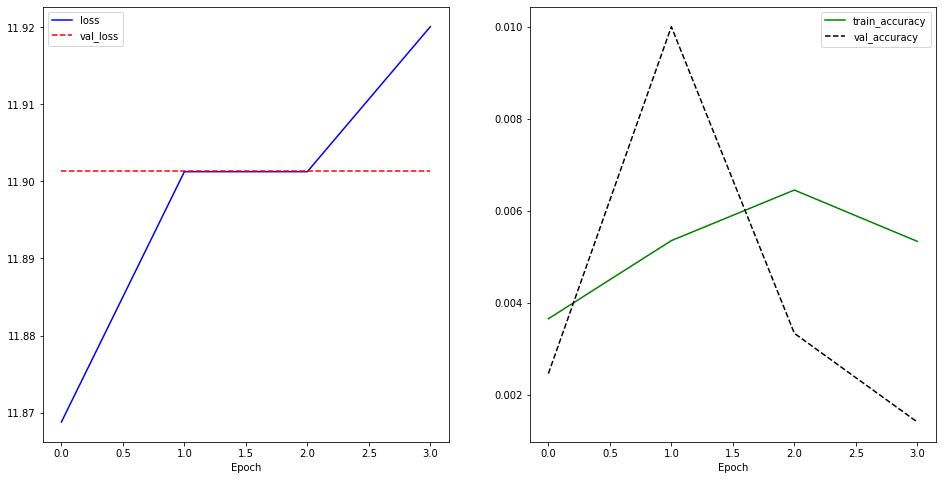

In [ ]:
history_plot(pretrain_history) #결과 시각화 

### non-pretrain의 loss와 accuracy 그래프
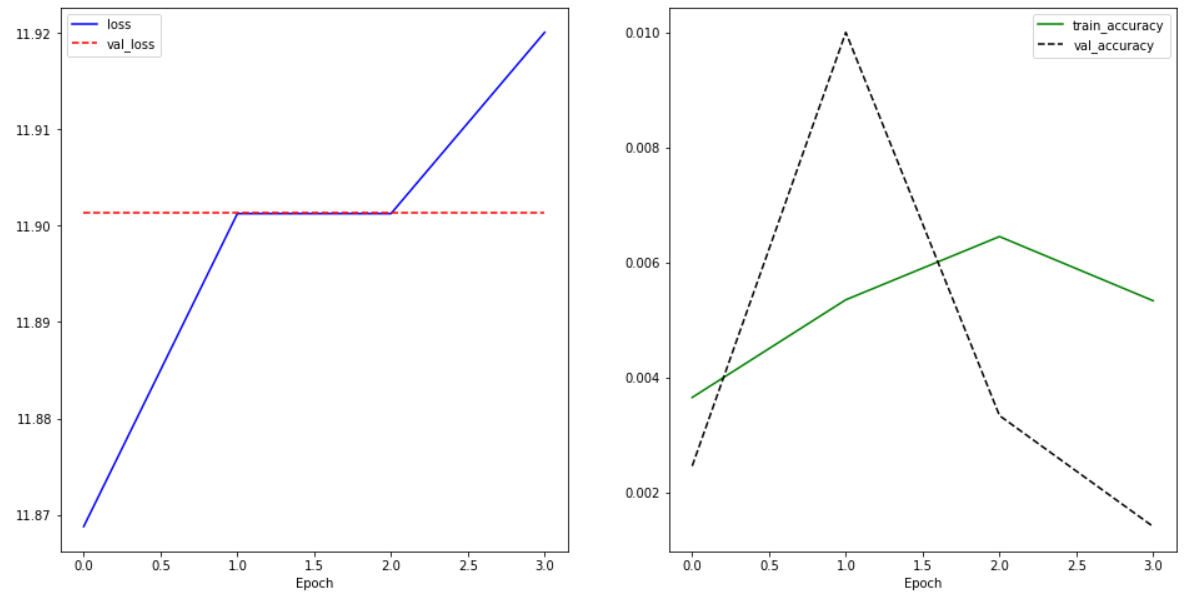

# Result  
● pretrain을 하지 않은 경우와 pretrain을 한 경우 비슷한 결과가 나왔습니다.  
● 둘 다 validation loss 변화가 없고 validation accuracy는 증가하다 감소하는 경향을 보였습니다.  

### 두번째 pretrain model (n_vocab=32007)

In [ ]:
checkpoint_file = '/aiffel/aiffel/bert_qna/data/snd_korquad_bert_pretrain.hdf5'

pretrained_model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    pretrained_model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    #pretrained_model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)
    pretrained_model.load_weights(checkpoint_file, by_name=True)
    pretrained_model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  41819648  
_________________________________________________________________
dense_145 (Dense)            multiple                  1026      
Total params: 41,820,674
Trainable params: 41,820,674
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bert_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] } #loss, acc 저장
snd_pretrain_history = train_model(bert_history, pretrained_model, train_dataset, dev_dataset)#모델 학습

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9507, acc: 0.0014, 0.0002
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 5.9507, 5.9507, acc: 0.0035, 0.0004
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 5.9507, 5.9507, acc: 0.0021, 0.0039
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 3 >> loss: 5.9507, 5.9507, acc: 0.0035, 0.0039
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 4 >> loss: 5.9507, 5.9507, acc: 0.0000, 0.0011


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 5 >> loss: 5.9507, 5.9507, acc: 0.0037, 0.0007
early stopping


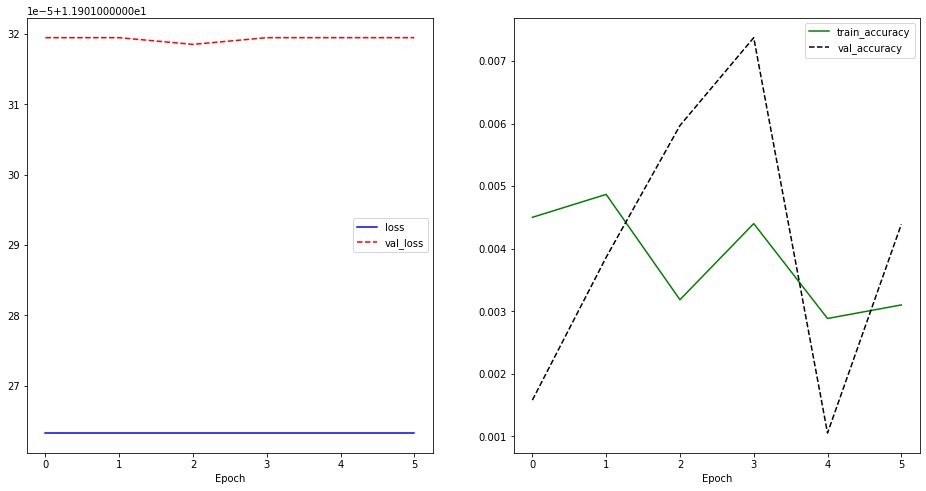

In [ ]:
history_plot(snd_pretrain_history) #결과 시각화

### non-pretrain model의 그래프  
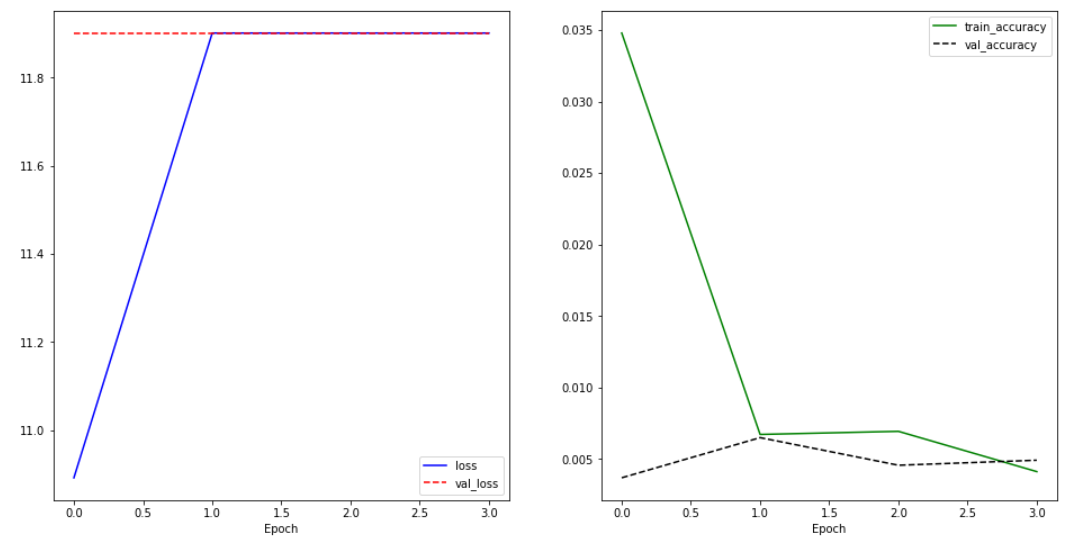

In [ ]:
corr_dict3 = {'question': [], 'context': [], 'answer': [], 'predicted_answer': [] } #예측 답에 정답이 포함 된 경우 저장
wrong_dict3 = {'question': [], 'context': [], 'answer': [], 'predicted_answer': [] } #예측 답에 정답이 없는 경우 or 아예 예측을 못한 경우 
corr_dict3, wrong_dict3 = get_predict(corr_dict3, wrong_dict3, model, dev_json=dev_json) 

41
질문 :  노아의 방주에 대해 기록하고있는 복음서는 무엇인가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 :  창세기
예측 :  3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 

44
질문 :  노아의 방주는 몇층으로 구성되어 있었는가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하

In [ ]:
corr_dict3 = pd.DataFrame(corr_dict3) #데이터프레임 변형 
corr_dict3.to_pickle('pretrained_correct_answers.pkl') #pickle 파일로 저장 
corr_dict3.head()

,question,context,answer,predicted_answer
0,노아의 방주에 대해 기록하고있는 복음서는 무엇인가?,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",창세기,"3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에..."
1,노아의 방주는 몇층으로 구성되어 있었는가?,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",3층,"3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에..."
2,1규빗을 미터법으로 환산하면 얼마인가?,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",45~46cm,규빗을 미터법으로 환산하면 얼마인가?[SEP] 노아는 하나님의 명령에 따라 배를 만...


In [ ]:
wrong_dict3 = pd.DataFrame(wrong_dict3) #데이터프레임 변환
wrong_dict3.to_pickle('pretrained_wrong_answers.pkl') #pickle 파일로 저장 
wrong_dict3.head()

,question,context,answer,predicted_answer
0,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,1989년 2월 15일,
1,1989년 6월 30일 평양축전에 대표로 파견 된 인물은?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임수경,
2,임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,1989년,
3,임종석을 검거한 장소는 경희대 내 어디인가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,학생회관 건물 계단,
4,임종석이 조사를 받은 뒤 인계된 곳은 어딘가?,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,서울지방경찰청 공안분실,


# Result  
● non-pretrain 모델 보다 정답이 포함된 예측 답의 개수가 훨씬 적었습니다.(3개)  
● validation의 loss가 너무 크고(심지어 non-pretrain 모델 보다 훨씬 높았습니다.) validation accuracy는 증가하다 네 번째 epoch에서 확 꺾였고 다섯번째 epoch에서 다시 증가하는 형태를 보입니다.  

# Further thoughts   
● KorQuAD1.0 공식 홈페이지에 들어가면 Dev set에 대해 만족하는 모델을 leaderboard에 올리고 평가점수를 얻을 수 있는데 평가지표는 EM과 F1 score입니다.  
● 현재 삼성 SDS AI research 팀이 1위고 EM은 80.17, F1 score는 95.57로 인간의 능력(EM=80.17, F1 score=91.20)을 뛰어넘었습니다.  
● 여기서 궁금한 점은 nlp 분야에서 사용하는 f1 score가 머신러닝에서 사용하는 f1 score와 일치하지 않을 것 같다는 것입니다. 그래서 nlp 분야에서 f1 score가 무엇을 뜻하고 어떻게 계산되는지 찾아봤습니다.  
  
### MRC(Machine reading comprehension)  
● 주어진 지문(context)를 이해하고 주어진 질의(Query/Question)의 답변을 추론하는 문제  
● Extractive Answer Dataset  
→ 질의에 대한 답이 항상 주어진 지문의 segment(or span)으로 존재  
→ KorQuAD는 이 중 Span Extraction에 해당  

### MRC 평가방법   
  
#### Exact Match (EM)  
● EM score는 예측 값과 정답이 캐릭터 단위로 완전히 똑같을 경우에만 1점을 부여한다.  
● 정답과 예측한 답이 완전히 일치하는 경우가 드물기 때문에 대부분의 점수가 0점이 될 수 있다.  
● 계산방법은 맞은 sample 수 / 전체 sample 수  
→ 나의 경우 EM은 0이 됨...  
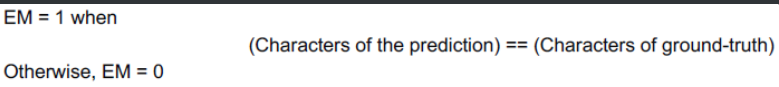  
***  
#### F1 Score  
● 예측한 답과 ground truth 사이의 token overlap을 F1으로 계산  
● precision:불필요하게 예측값이 길어지면 하락  
● recall: 두 token 중 겹치는 token이 적으면 하락  
● 0과 1 사이의 부분 점수를 받을 수 있음  
● f1 score의 경우 단어의 overlap 만으로 평가하다보니 답변 자체의 언어적인 부분을 평가하기 힘들다.  
● f1 구하는 코드(코드는 KorQuAD1.0 공식 홈페이지에서 evaluate 파일을 참고하였습니다.)  
```python
    precision = 1.0 * num_same / len(prediction_Char)
    recall = 1.0 * num_same / len(ground_truth_Char)
    f1 = (2 * precision * recall) / (precision + recall)
```
    → num_same:정답과 예측 답 간에 겹치는 토큰의 개수  
    → prediction_Char:예측 답 토큰  
    → ground_truth_Char: 정답 토큰  
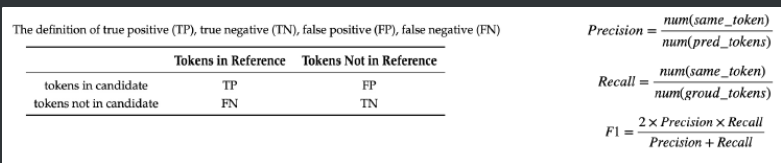  
***  
# Discussion  
● BERT는 학습 시킬 때 시간이 정말 오래 걸린다는 단점이 있었습니다. 거의 4일을 꼬박 학습에만 투자했던 것 같습니다.  
● 하지만 기대한 성능만큼은 나오지 않아 실망스러웠습니다.  
● pretrain이 non-pretrain 보다 성능이 비슷하거나 떨어져 하이퍼파라미터 조정이 필요합니다.(시간 관계상 거기까진 못했습니다.)  
● 현재 코드에서 f1 score를 계산하는 코드를 고민해 보면 좋을 것 같습니다.  
[reference](https://www.ohsuz.dev/mrc-cookbook/mrc-lecture-01)  